In [1]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


In [2]:
import datasets 
#load dataset
dataset=datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')
cogs402_ds = datasets.load_dataset("danielhou13/cogs402dataset")

Reusing dataset hyperpartisan_news_detection (C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration danielhou13--cogs402dataset-5c7aa10e6c95142f
Reusing dataset parquet (C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset-5c7aa10e6c95142f\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
#import huggingface models
from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

#base model for training 
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096",num_labels=4)
# model2 = LongformerForSequenceClassification.from_pretrained("models/longformer-finetuned_both/checkpoint-7356",num_labels=4)

#import same version from hub
model3 = LongformerForSequenceClassification.from_pretrained("danielhou13/longformer-finetuned_v2_cogs402",num_labels=2)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weigh

In [4]:
#seperate the two splits for both datasets
train_ds = dataset["train"]
eval_ds = dataset["validation"]

train_ds2 = cogs402_ds["train"]
eval_ds2 = cogs402_ds["test"]

#convert hyperpartisan to correct format (from true/false to 1/0)
labels = map(int, train_ds['hyperpartisan'])
labels = list(labels)

labels2 = map(int, eval_ds['hyperpartisan'])
labels2 = list(labels2)

#update labels on cogs402ds
labels3 = map(lambda x: x+2, train_ds2['labels'])
labels3 = list(labels3)

labels4 = map(lambda x: x+2, eval_ds2['labels'])
labels4 = list(labels4)

#add the columns to the dataset
train_ds = train_ds.add_column("labels", labels)
eval_ds = eval_ds.add_column("labels", labels2)
print(train_ds)

Dataset({
    features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias', 'labels'],
    num_rows: 600000
})


In [5]:
#remove old labels column
train_ds2 = train_ds2.remove_columns(['labels'])
eval_ds2 = eval_ds2.remove_columns(['labels'])

In [6]:
#replace with new labels column
train_ds2 = train_ds2.add_column("labels", labels3)
eval_ds2 = eval_ds2.add_column("labels", labels4)
print(train_ds2)

Dataset({
    features: ['text', 'labels'],
    num_rows: 4715
})


In [7]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [8]:
## Take subset of data from news
train_size = 10000
val_size = 2000
import numpy as np

train_indices = np.random.randint(0, len(train_ds), train_size)
val_indices = np.random.randint(0, len(eval_ds), val_size)
train_ds = train_ds.select(train_indices)
val_ds = eval_ds.select(val_indices)

#tokenize the data for papers
train_dataset = train_ds.map(tokenize, load_from_cache_file=False)
val_dataset = val_ds.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [9]:
#tokenize the data for papers
train_dataset2 = train_ds2.map(tokenize, load_from_cache_file=False)
val_dataset2 = eval_ds2.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [10]:
#remove unnessesary columns and convert needed ones to torch format
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
train_dataset2.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset2.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

#remove extra columns from news
train_dataset = train_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
val_dataset = val_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
print(train_dataset)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 10000
})


In [11]:
#remove extra column from papers
train_dataset2 = train_dataset2.remove_columns(['text'])
val_dataset2 = val_dataset2.remove_columns(['text'])

In [12]:
#combine both datasets
from datasets import concatenate_datasets

train_data = concatenate_datasets([train_dataset, train_dataset2])
val_data = concatenate_datasets([val_dataset, val_dataset2])
print(train_data)
print(train_data["labels"])

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 14715
})
tensor([0, 0, 0,  ..., 2, 3, 2])


In [13]:
print(val_data)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3179
})


In [14]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model2.to(device)
device

device(type='cuda')

In [16]:
#create checkpointing folder if doesn't exist
if not os.path.exists("models"):
    os.mkdir("models")

In [17]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) //gradient_acc
model_name = f"longformer-finetuned_both"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch")
print(logging_steps)

2500


In [18]:
#create the metrics we want to find out, can import othe things like precision, recall if needed
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [19]:
trainer = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)


In [26]:
trainer.train()

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.395800,0.285353,0.929538,0.929448
1,0.251300,0.296606,0.941806,0.941753


TrainOutput(global_step=7356, training_loss=0.27903189978047255, metrics={'train_runtime': 15034.9086, 'train_samples_per_second': 1.957, 'train_steps_per_second': 0.489, 'total_flos': 3.886474087738968e+16, 'train_loss': 0.27903189978047255, 'epoch': 2.0})

In [20]:
preds_output = trainer.predict(val_data)

In [21]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_data["labels"])

In [22]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["false", "true", "PL", "AI"]
    )
)

              precision    recall  f1-score   support

       false       0.96      0.93      0.95       967
        true       0.94      0.97      0.95      1033
          PL       0.88      0.97      0.92       571
          AI       0.97      0.88      0.92       608

    accuracy                           0.94      3179
   macro avg       0.94      0.94      0.94      3179
weighted avg       0.94      0.94      0.94      3179



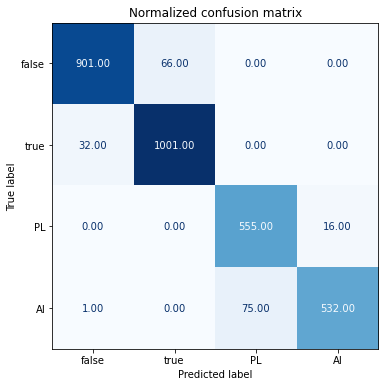

(3179,)
(3179,)


In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["false", "true", "PL", "AI"])
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels=[0,1])
print(y_true.shape)
print(y_preds.shape)

In [24]:
# # upload this dataset to huggingface
# from huggingface_hub import notebook_login

# notebook_login()

In [25]:
# # upload model to huggingface for storage
# # replace danielhou13 with personal user
# model.push_to_hub("danielhou13/longformer-finetuned_v2_cogs402")

C:\Users\danie\miniconda3\lib\site-packages\huggingface_hub\hf_api.py:1001: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/danielhou13/longformer-finetuned_v2_cogs402 into local empty directory.


Download file pytorch_model.bin:   0%|          | 17.6k/567M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/567M [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 32.0k/567M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/danielhou13/longformer-finetuned_v2_cogs402
   3a43281..1356be7  main -> main



'https://huggingface.co/danielhou13/longformer-finetuned_v2_cogs402/commit/1356be7ad14f916d4cde36d8a60416ebe2864e05'